<a href="https://colab.research.google.com/github/martinpius/PG_training/blob/main/app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Set random seed for reproducibility
np.random.seed(19203)

### Simulate Covariates & Survival Data**
N = 500  # Number of individuals
X = np.random.normal(size=(N, 2))  # Two covariates

# True Beta coefficients
beta_true = np.array([0.5, -0.3])

# Generate hazard rates
lambda_exp_true = np.exp(X @ beta_true)  # Exponential model
rho_true = 1.5  # Shape parameter for Weibull
lambda_weib_true = np.exp(X @ beta_true)  # Weibull model

# Generate survival times [Inverse transform]
U = np.random.uniform(size=N)
T_exp = -np.log(U) / lambda_exp_true  # Exponential survival times
T_weib = (-np.log(U) / lambda_weib_true) ** (1 / rho_true)  # Weibull survival times

# Generate censoring times
C = np.random.uniform(1, 10, size=N)
event_exp = T_exp < C  # 1 if event occurs, 0 if censored
event_weib = T_weib < C  # 1 if event occurs, 0 if censored

# Observed times (min of survival and censoring)
T_exp_observed = np.minimum(T_exp, C)
T_weib_observed = np.minimum(T_weib, C)

# Store as dataframe
df = pd.DataFrame({"T_exp": T_exp_observed, "event_exp": event_exp,
                   "T_weib": T_weib_observed, "event_weib": event_weib,
                   "X1": X[:, 0], "X2": X[:, 1]})

In [ ]:
display(df.head(10))

,T_exp,event_exp,T_weib,event_weib,X1,X2
0,0.153352,True,0.286501,True,-0.678771,-0.301564
1,0.093576,True,0.206115,True,-1.742208,-1.418742
2,0.996256,True,0.997502,True,1.235610,-0.272758
3,0.304768,True,0.452876,True,0.440870,-0.327103
4,0.546773,True,0.668659,True,-0.289186,0.194893
5,0.134850,True,0.262967,True,0.702314,-0.624708
6,0.339010,True,0.486193,True,0.331620,0.190419
7,0.086251,True,0.195214,True,-0.171948,0.286686
8,0.269832,True,0.417570,True,-2.075859,-0.438747
9,0.012560,True,0.054032,True,1.873388,-1.603815


Estimated Exponential λ: 0.8827
Estimated Weibull ρ: 1.2146, λ: 0.9037


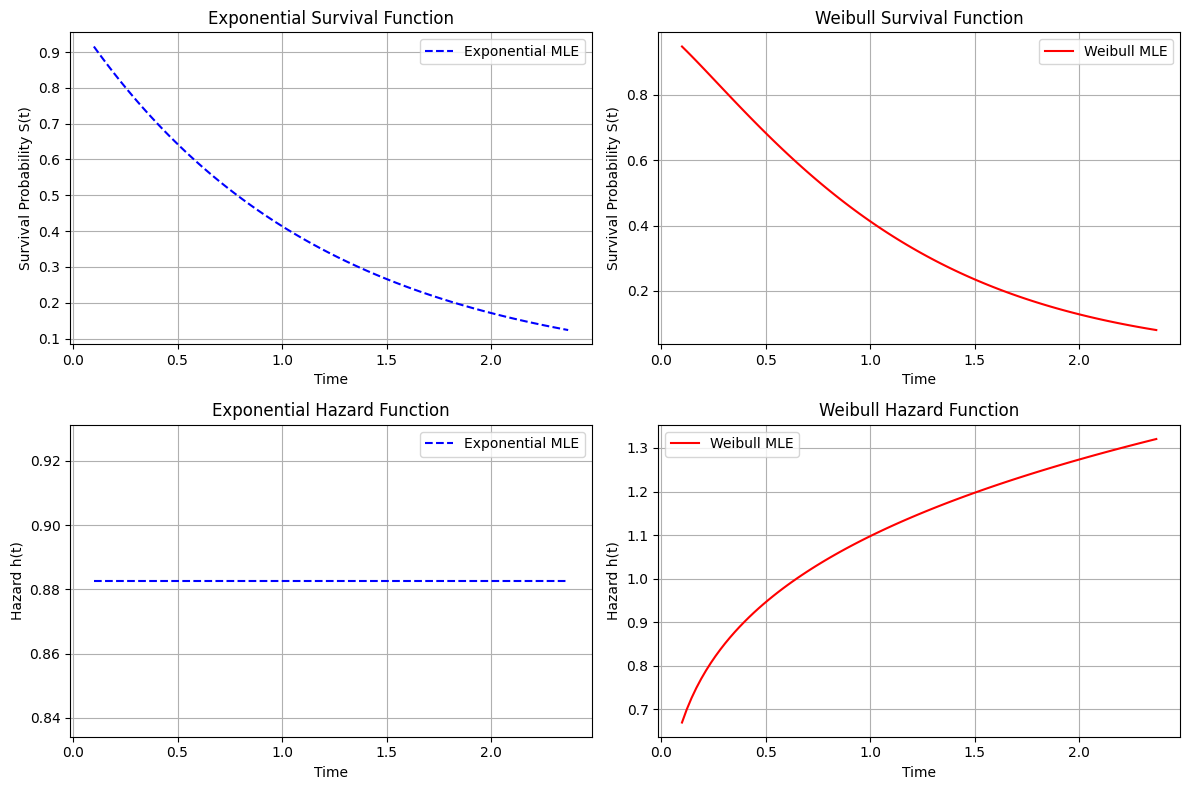

In [ ]:
#  Compute MLE for Exponential Model
lambda_exp_mle = np.sum(event_exp) / np.sum(T_exp_observed)

# Compute MLE for Weibull Model via Gradient Ascent
def weibull_mle_gradient_ascent(times, events, max_iter=5000, lr=0.001, tol=1e-6):
    """
    Estimate MLE for Weibull model using gradient ascent.
    """
    # Initialize parameters
    rho = 1.0  # Shape parameter (starts with Exponential assumption)
    lambda_hat = 1 / np.mean(times)  # Scale parameter initialization

    for _ in range(max_iter):
        # Compute gradients for log-likelihood
        dlambda = np.sum(events / lambda_hat) - rho * np.sum((lambda_hat * times) ** rho)
        drho = (
            np.sum(events / rho)
            + np.sum(events * np.log(lambda_hat * times))
            - np.sum((lambda_hat * times) ** rho * np.log(lambda_hat * times))
        )

        # Update parameters
        lambda_new = lambda_hat + lr * dlambda
        rho_new = rho + lr * drho

        # Ensure stability
        lambda_new = max(lambda_new, 1e-6)
        rho_new = max(rho_new, 0.1)

        # Check for convergence
        if np.abs(lambda_new - lambda_hat) < tol and np.abs(rho_new - rho) < tol:
            break

        lambda_hat, rho = lambda_new, rho_new

    return lambda_hat, rho

# Fit Weibull Model via Gradient Ascent
lambda_weib_mle, rho_weib_mle = weibull_mle_gradient_ascent(T_weib_observed, event_weib)

print(f"Estimated Exponential λ: {lambda_exp_mle:.4f}")
print(f"Estimated Weibull ρ: {rho_weib_mle:.4f}, λ: {lambda_weib_mle:.4f}")

### Compute Survival & Hazard Functions
t_values = np.linspace(0.1, np.percentile(T_exp_observed, 90), 100)

# Exponential Survival & Hazard Functions
S_exp_mle = np.exp(-lambda_exp_mle * t_values)
h_exp_mle = lambda_exp_mle * np.ones_like(t_values)

# Weibull Survival & Hazard Functions
S_weib_mle = np.exp(-((lambda_weib_mle * t_values) ** rho_weib_mle))
h_weib_mle = rho_weib_mle * lambda_weib_mle * (t_values ** (rho_weib_mle - 1))

### Plot Survival & Hazard Curves
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot Exponential Survival
axs[0, 0].plot(t_values, S_exp_mle, label="Exponential MLE", linestyle="dashed", color="blue")
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel("Survival Probability S(t)")
axs[0, 0].set_title("Exponential Survival Function")
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot Weibull Survival
axs[0, 1].plot(t_values, S_weib_mle, label="Weibull MLE", linestyle="solid", color="red")
axs[0, 1].set_xlabel("Time")
axs[0, 1].set_ylabel("Survival Probability S(t)")
axs[0, 1].set_title("Weibull Survival Function")
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot Exponential Hazard
axs[1, 0].plot(t_values, h_exp_mle, label="Exponential MLE", linestyle="dashed", color="blue")
axs[1, 0].set_xlabel("Time")
axs[1, 0].set_ylabel("Hazard h(t)")
axs[1, 0].set_title("Exponential Hazard Function")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot Weibull Hazard
axs[1, 1].plot(t_values, h_weib_mle, label="Weibull MLE", linestyle="solid", color="red")
axs[1, 1].set_xlabel("Time")
axs[1, 1].set_ylabel("Hazard h(t)")
axs[1, 1].set_title("Weibull Hazard Function")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

### Step 1: GLM Framework

We use the **Exponential model** as a baseline and then extend it to the **Weibull model**.

#### Log-Likelihood for Exponential with Covariates

The hazard function with covariates:

$$ \lambda(t | X) = e^{\beta_0 + \beta_1 X_1 + \dots + \beta_p X_p} $$

The survival function becomes:

$$ S(t | X) = e^{-t e^{\beta_0 + \beta_1 X_1 + \dots + \beta_p X_p}} $$

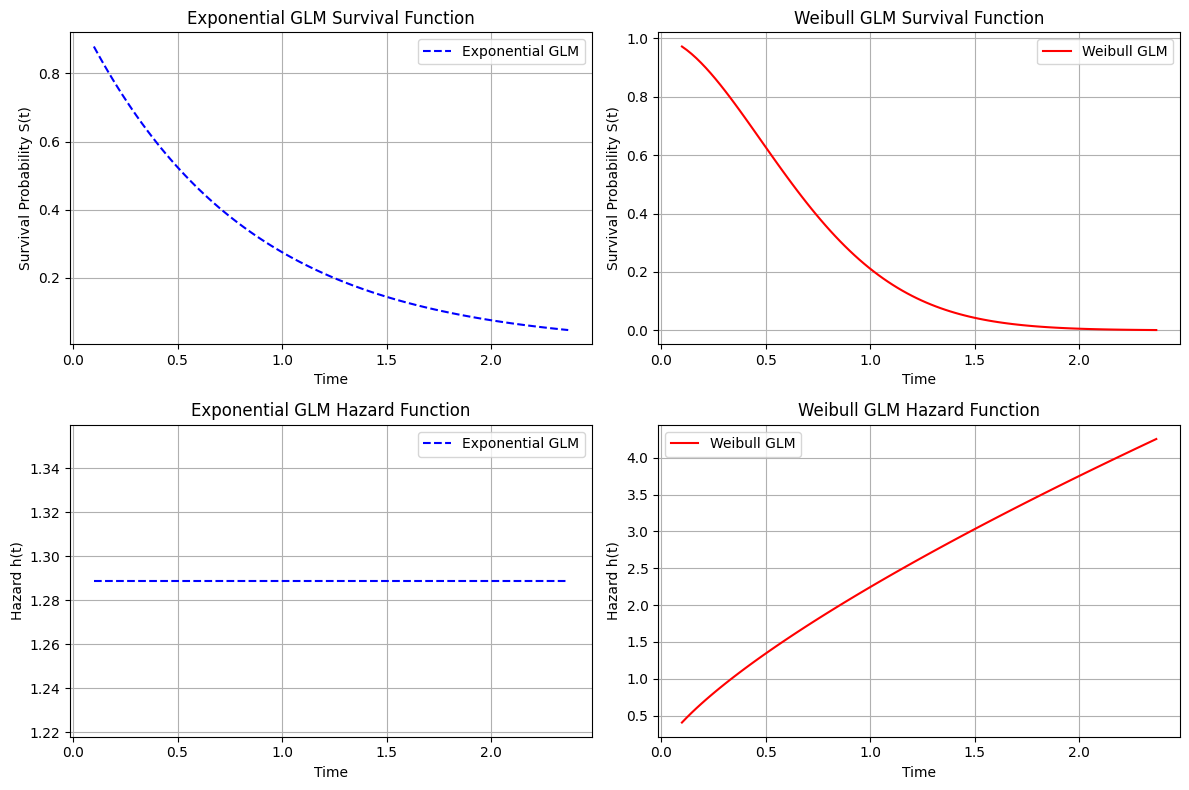

In [ ]:
###  Fit Exponential GLM**
def exponential_glm_mle(X, times, events, max_iter=5000, lr=0.001, tol=1e-6):
    beta = np.random.normal(0, 0.1, X.shape[1])  # Better initialization

    for _ in range(max_iter):
        linear_predictor = X @ beta
        hazard = np.exp(np.clip(linear_predictor, -10, 10))  # Prevent extreme values

        dbeta = X.T @ (events - hazard * times)
        beta_new = beta + lr * dbeta

        if np.linalg.norm(beta_new - beta) < tol:
            break

        beta = beta_new

    return beta

# Fit Exponential GLM
X_with_intercept = np.hstack([np.ones((N, 1)), X])
beta_exp_fit = exponential_glm_mle(X_with_intercept, df["T_exp"], df["event_exp"])

# Compute hazard and survival functions
lambda_exp_fit = np.exp(X_with_intercept @ beta_exp_fit)
t_values = np.linspace(0.1, np.percentile(df["T_exp"], 90), 100)
S_exp_fit = np.exp(-np.outer(t_values, lambda_exp_fit.mean()))
h_exp_fit = lambda_exp_fit.mean() * np.ones_like(t_values)

# Fit Weibull GLM
def weibull_glm_mle(X, times, events, max_iter=5000, lr=0.001, tol=1e-6):
    beta = np.random.normal(0, 0.1, X.shape[1])  # Better initialization
    rho = 1.0  # Shape parameter initialization

    for _ in range(max_iter):
        linear_predictor = X @ beta
        hazard = np.exp(np.clip(linear_predictor, -10, 10))  # Prevent extreme values

        rho = np.clip(rho, 0.5, 5.0)  # Prevent unstable values
        lambda_t_rho = hazard * (times ** (rho - 1))

        dbeta = X.T @ (events - lambda_t_rho * times)
        drho = np.sum(events / (rho + 1e-6) + events * np.log(np.maximum(hazard * times, 1e-6))
                      - lambda_t_rho * np.log(np.maximum(hazard * times, 1e-6)))

        beta_new = beta + lr * dbeta
        rho_new = rho + lr * drho

        if np.linalg.norm(beta_new - beta) < tol and abs(rho_new - rho) < tol:
            break

        beta, rho = beta_new, rho_new

    return beta, rho

# Fit Weibull GLM
beta_weib_fit, rho_weib_fit = weibull_glm_mle(X_with_intercept, df["T_weib"], df["event_weib"])

# Compute hazard and survival functions
lambda_weib_fit = np.exp(X_with_intercept @ beta_weib_fit)
S_weib_fit = np.exp(-((lambda_weib_fit.mean() * t_values) ** rho_weib_fit))
h_weib_fit = rho_weib_fit * lambda_weib_fit.mean() * (t_values ** (rho_weib_fit - 1))

# Plot Survival & Hazard Curves
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot Exponential Survival
axs[0, 0].plot(t_values, S_exp_fit, label="Exponential GLM", linestyle="dashed", color="blue")
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel("Survival Probability S(t)")
axs[0, 0].set_title("Exponential GLM Survival Function")
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot Weibull Survival
axs[0, 1].plot(t_values, S_weib_fit, label="Weibull GLM", linestyle="solid", color="red")
axs[0, 1].set_xlabel("Time")
axs[0, 1].set_ylabel("Survival Probability S(t)")
axs[0, 1].set_title("Weibull GLM Survival Function")
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot Exponential Hazard
axs[1, 0].plot(t_values, h_exp_fit, label="Exponential GLM", linestyle="dashed", color="blue")
axs[1, 0].set_xlabel("Time")
axs[1, 0].set_ylabel("Hazard h(t)")
axs[1, 0].set_title("Exponential GLM Hazard Function")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot Weibull Hazard
axs[1, 1].plot(t_values, h_weib_fit, label="Weibull GLM", linestyle="solid", color="red")
axs[1, 1].set_xlabel("Time")
axs[1, 1].set_ylabel("Hazard h(t)")
axs[1, 1].set_title("Weibull GLM Hazard Function")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()